# efd2.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter1d
from scipy.spatial.distance import euclidean

import os
import json
import pandas as pd
from pathlib import Path
import sqlite3
from icecream import ic
import glob


# FUNCTIONS
```python
def clean_contour(contour: np.ndarray, sigma:float=1.0) -> np.ndarray:
    """Internal: Removes spikes and jitter."""

def calculate_efd(contour:np.ndarray, harmonics:int=20) -> np.ndarray:
    """Internal: Standard Kuhl and Giardina EFD math."""

def get_feature_vector(contour:np.ndarray) -> np.ndarray:
    """Processes a polygon and returns a normalized 1D feature vector."""

def normalize(coeffs:np.ndarray) -> np.ndarray:
    """Internal: Rotation, size, and starting-point invariance."""

def reconstruct(feature_vector:np.ndarray, num_points:int=200) -> tuple[np.ndarray, np.ndarray] :
    """Reconstructs (x, y) coordinates from a feature vector."""

def visualize_harmonics(contour:np.ndarray, harmonic_list:list[int]=[1, 3, 10, 50]) -> None:
    """Plots original vs reconstructed shapes for various harmonics."""

def load_polygon(file_path: str) -> np.ndarray:
    """Loads coordinates from CSV or JSON."""

def process_directory(input_dir:str, output_csv:str="shape_features.csv", harmonics:int=20) -> pd.DataFrame:
    """ 
    Data Requirements

    To ensure the script runs smoothly, your files should be structured as follows:
    Format	Expected Structure
    CSV	Two columns (X, Y) without a header, or with headers x and y.
    JSON	A simple list of lists: [[x1, y1], [x2, y2], ...] or a dictionary with a "coordinates" key.
    """    

def save_coords_to_csv(coords_array:np.ndarray, filename:str="coordinates.csv") -> None:
    """
    Saves a 2D numpy array of coordinates to a CSV file.

    Parameters:
    coords_array (np.ndarray): A 2D numpy array where each row is [x, y].
    filename (str): The name of the output CSV file.
    """
```



In [2]:
# from class
def clean_contour(contour: np.ndarray, sigma:float=1.0) -> np.ndarray:
    """Internal: Removes spikes and jitter."""
    x, y = contour[:, 0], contour[:, 1]
    x = median_filter(x, size=3, mode='wrap')
    y = median_filter(y, size=3, mode='wrap')
    x_smooth = gaussian_filter1d(x, sigma, mode='wrap')
    y_smooth = gaussian_filter1d(y, sigma, mode='wrap')
    return np.column_stack([x_smooth, y_smooth])


In [3]:
# From class
def calculate_efd(contour:np.ndarray, harmonics:int=20) -> np.ndarray:
    """Internal: Standard Kuhl and Giardina EFD math."""
   
    # Ensure the contour is closed
    if not np.allclose(contour[0], contour[-1]):
        contour = np.vstack([contour, contour[0]])
   
    dxy = np.diff(contour, axis=0)
    dt = np.sqrt((dxy**2).sum(axis=1))
    t = np.concatenate([[0], np.cumsum(dt)])
    T = t[-1]
    
    coeffs = np.zeros((harmonics, 4))
    for n in range(1, harmonics + 1):
        term = 2 * np.pi * n / T
        factor = T / (2 * (n * np.pi)**2)
        
        an = factor * np.sum((dxy[:, 0] / dt) * (np.cos(term * t[1:]) - np.cos(term * t[:-1])))
        bn = factor * np.sum((dxy[:, 0] / dt) * (np.sin(term * t[1:]) - np.sin(term * t[:-1])))
        cn = factor * np.sum((dxy[:, 1] / dt) * (np.cos(term * t[1:]) - np.cos(term * t[:-1])))
        dn = factor * np.sum((dxy[:, 1] / dt) * (np.sin(term * t[1:]) - np.sin(term * t[:-1])))
        coeffs[n-1] = [an, bn, cn, dn]
    return coeffs

In [4]:
# from class
def get_feature_vector(contour:np.ndarray) -> np.ndarray:
    """Processes a polygon and returns a normalized 1D feature vector."""
    # cleaned = clean_contour(contour)
    # coeffs = calculate_efd(cleaned)
    coeffs = calculate_efd(contour, 50)
    return normalize(coeffs)

In [5]:
# from class
def normalize(coeffs:np.ndarray) -> np.ndarray:
    """Internal: Rotation, size, and starting-point invariance."""
    a1, b1, c1, d1 = coeffs[0]
    theta_1 = 0.5 * np.arctan2(2 * (a1 * b1 + c1 * d1), (a1**2 + c1**2 - b1**2 - d1**2))
    
    a1_p = a1 * np.cos(theta_1) + b1 * np.sin(theta_1)
    c1_p = c1 * np.cos(theta_1) + d1 * np.sin(theta_1)
    psi_1 = np.arctan2(c1_p, a1_p)
    E = np.sqrt(a1_p**2 + c1_p**2)
    
    norm_v = []
    for n in range(len(coeffs)):
        an, bn, cn, dn = coeffs[n]
        cos_nt = np.cos((n + 1) * theta_1)
        sin_nt = np.sin((n + 1) * theta_1)
        cp, sp = np.cos(psi_1), np.sin(psi_1)
        
        # Standard matrix transformations for normalization
        an_n = (1/E) * (cp * (an*cos_nt + bn*sin_nt) + sp * (cn*cos_nt + dn*sin_nt))
        bn_n = (1/E) * (cp * (-an*sin_nt + bn*cos_nt) + sp * (-cn*sin_nt + dn*cos_nt))
        cn_n = (1/E) * (-sp * (an*cos_nt + bn*sin_nt) + cp * (cn*cos_nt + dn*sin_nt))
        dn_n = (1/E) * (-sp * (-an*sin_nt + bn*cos_nt) + cp * (-cn*sin_nt + dn*cos_nt))
        norm_v.extend([an_n, bn_n, cn_n, dn_n])
    return np.array(norm_v)


In [6]:
#from class
# @staticmethod
def reconstruct(feature_vector:np.ndarray, num_points:int=200) -> tuple[np.ndarray, np.ndarray] :
    """Reconstructs (x, y) coordinates from a feature vector."""
    coeffs = feature_vector.reshape(-1, 4)
    t = np.linspace(0, 2 * np.pi, num_points)
    x, y = np.zeros(num_points), np.zeros(num_points)
    for n, (a, b, c, d) in enumerate(coeffs):
        h = n + 1
        x += a * np.cos(h * t) + b * np.sin(h * t)
        y += c * np.cos(h * t) + d * np.sin(h * t)
    return x, y

# Usage example

# # Initialize your analyzer
# analyzer = ShapeDescriptor(harmonics=15, smoothing_sigma=1.2)

# # Process two different shapes
# feat1 = analyzer.get_feature_vector(polygon_data_1)
# feat2 = analyzer.get_feature_vector(polygon_data_2)

# # Compare them
# dist = euclidean(feat1, feat2)
# print(f"Morphological distance: {dist:.4f}")

# # Visualize the normalized reconstruction
# x, y = analyzer.reconstruct(feat1)
# plt.plot(x, y)
# plt.axis('equal')
# plt.show()


In [7]:

# END OF FROM CLASS IN FOLLOWING CELL
#####################################

# def calculate_efd(contour, num_harmonics=10):
#     """Calculates Elliptic Fourier Descriptors for a closed polygon."""
#     # Ensure the contour is closed
#     if not np.allclose(contour[0], contour[-1]):
#         contour = np.vstack([contour, contour[0]])

#     dxy = np.diff(contour, axis=0)
#     dt = np.sqrt((dxy**2).sum(axis=1))
#     t = np.concatenate([[0], np.cumsum(dt)])
#     T = t[-1]

#     phi = (2 * np.pi * t) / T
    
#     coeffs = np.zeros((num_harmonics, 4))
    
#     for n in range(1, num_harmonics + 1):
#         # Calculate components for each harmonic
#         term = 2 * np.pi * n / T
        
#         # Integration using the trapezoidal rule for the polygon segments
#         a_n = (T / (2 * (n * np.pi)**2)) * np.sum(
#             (dxy[:, 0] / dt) * (np.cos(term * t[1:]) - np.cos(term * t[:-1]))
#         )
#         b_n = (T / (2 * (n * np.pi)**2)) * np.sum(
#             (dxy[:, 0] / dt) * (np.sin(term * t[1:]) - np.sin(term * t[:-1]))
#         )
#         c_n = (T / (2 * (n * np.pi)**2)) * np.sum(
#             (dxy[:, 1] / dt) * (np.cos(term * t[1:]) - np.cos(term * t[:-1]))
#         )
#         d_n = (T / (2 * (n * np.pi)**2)) * np.sum(
#             (dxy[:, 1] / dt) * (np.sin(term * t[1:]) - np.sin(term * t[:-1]))
#         )
        
#         coeffs[n-1] = [a_n, b_n, c_n, d_n]
        
#     return coeffs

# def normalize_efd(coeffs):
#     """Normalizes coefficients for size, rotation, and starting point invariance."""
#     # 1. Size invariance: Scale by the semi-major axis of the first harmonic
#     a1, b1, c1, d1 = coeffs[0]
#     r1 = np.sqrt(a1**2 + c1**2) # Simplified magnitude for scaling
    
#     # Optional: Full Kuhl-Giardina normalization involves calculating 
#     # the phase shift and rotation angle from the first harmonic ellipse.
#     # For general size-comparison, dividing by r1 is the most critical step.
#     return coeffs / r1

# def reconstruct_efd(coeffs, num_points=200):
#     """Reconstructs a shape from its Fourier descriptors."""
#     t = np.linspace(0, 2 * np.pi, num_points)
#     x = np.zeros(num_points)
#     y = np.zeros(num_points)
    
#     for n, (a, b, c, d) in enumerate(coeffs):
#         harm = n + 1
#         x += a * np.cos(harm * t) + b * np.sin(harm * t)
#         y += c * np.cos(harm * t) + d * np.sin(harm * t)
        
#     return x, y


In [8]:

def visualize_harmonics(contour: np.ndarray, harmonic_list: list[int]=[1, 3, 10, 50]) -> None:
    """Plots original vs reconstructed shapes for various harmonics."""
    plt.figure(figsize=(15, 5))
    
    # Plot Original
    plt.subplot(1, len(harmonic_list) + 1, 1)
    plt.plot(contour[:, 0], contour[:, 1], 'k--', alpha=0.5)
    plt.title("Original Boundary")
    plt.axis('equal')
    
    for i, n in enumerate(harmonic_list):
        coeffs = calculate_efd(contour, num_harmonics=n)
        # We don't use normalized coeffs for reconstruction overlay 
        # so they sit on top of the original shape
        rx, ry = reconstruct_efd(coeffs)
        
        plt.subplot(1, len(harmonic_list) + 1, i + 2)
        plt.plot(contour[:, 0], contour[:, 1], 'k--', alpha=0.2)
        plt.plot(rx, ry, 'r')
        plt.title(f"Harmonics: {n}")
        plt.axis('equal')
        
    plt.tight_layout()
    plt.show()

# # --- Example Usage ---
# # Creating a dummy "star" shape with noise to simulate a complicated boundary
# t_orig = np.linspace(0, 2*np.pi, 100)
# r = 10 + 3*np.sin(5*t_orig) + np.random.normal(0, 0.2, 100)
# x_orig = r * np.cos(t_orig)
# y_orig = r * np.sin(t_orig)
# sample_contour = np.column_stack([x_orig, y_orig])

# visualize_harmonics(sample_contour)



In [9]:
def load_polygon(file_path: str) -> np.ndarray:
    """Loads coordinates from CSV or JSON."""
    ext = file_path.suffix.lower()
    
    if ext == '.csv':
        # Assumes columns are 'x' and 'y' or just two columns of data
        data = pd.read_csv(file_path).values
        return data
    
    elif ext == '.json':
        with open(file_path, 'r') as f:
            data = json.load(f)
            # Adjust 'coordinates' key based on your specific JSON structure
            return np.array(data.get('coordinates', data))
            
    return None

def process_directory(input_dir:str, output_csv:str="shape_features.csv", harmonics:int=20) -> pd.DataFrame:
    """ 
    Data Requirements

    To ensure the script runs smoothly, your files should be structured as follows:
    Format	Expected Structure
    CSV	Two columns (X, Y) without a header, or with headers x and y.
    JSON	A simple list of lists: [[x1, y1], [x2, y2], ...] or a dictionary with a "coordinates" key.
    """    
    
    input_path = Path(input_dir)
    all_features = []
    filenames = []

    # Supported formats
    valid_extensions = ('.csv', '.json')
    
    print(f"Scanning {input_dir} for shape files...")

    for file in input_path.iterdir():
        if file.suffix.lower() in valid_extensions:
            try:
                contour = load_polygon(file)
                if contour is None or len(contour) < 3:
                    continue
                
                # 1. Calculate raw EFD
                coeffs = calculate_efd(contour, num_harmonics=harmonics)
                
                # 2. Get normalized feature vector (from previous step)
                vector = get_feature_vector(coeffs)
                
                all_features.append(vector)
                filenames.append(file.name)
                
            except Exception as e:
                print(f"Skipping {file.name} due to error: {e}")

    # Create a DataFrame
    # Columns will be named h1_an, h1_bn, h1_cn, h1_dn, h2_an...
    col_names = []
    for h in range(1, harmonics + 1):
        col_names.extend([f'h{h}_an', f'h{h}_bn', f'h{h}_cn', f'h{h}_dn'])
    
    df = pd.DataFrame(all_features, columns=col_names)
    df.insert(0, 'filename', filenames)
    
    # Save to disk
    df.to_csv(output_csv, index=False)
    print(f"Success! Processed {len(filenames)} shapes. Saved to {output_csv}")
    return df

# Example Run:
df = process_directory("./temp_csv", harmonics=15)

Scanning ./temp_csv for shape files...
Skipping 20251129_152106-obj16.csv due to error: calculate_efd() got an unexpected keyword argument 'num_harmonics'. Did you mean 'harmonics'?
Skipping 08hs-palms-03-zglw-superJumbo-obj00.csv due to error: calculate_efd() got an unexpected keyword argument 'num_harmonics'. Did you mean 'harmonics'?
Skipping 20251129_152106-obj05.csv due to error: calculate_efd() got an unexpected keyword argument 'num_harmonics'. Did you mean 'harmonics'?
Skipping 08hs-palms-03-zglw-superJumbo-obj01.csv due to error: calculate_efd() got an unexpected keyword argument 'num_harmonics'. Did you mean 'harmonics'?
Success! Processed 0 shapes. Saved to shape_features.csv


In [10]:
def save_coords_to_csv(coords_array:np.ndarray, filename:str="coordinates.csv") -> None:
    """
    Saves a 2D numpy array of coordinates to a CSV file.

    Parameters:
    coords_array (np.ndarray): A 2D numpy array where each row is [x, y].
    filename (str): The name of the output CSV file.
    """
    if coords_array.shape[1] != 2:
        raise ValueError("Input array must have exactly two columns (x, y).")
        
    # Use numpy.savetxt to save the array directly as a CSV
    np.savetxt(
        filename,
        coords_array,
        delimiter=",",  # Use comma as the separator
        fmt='%.1f'      # Format each number as a float with 6 decimal places (adjust as needed)
    )
    print(f"Successfully saved {len(coords_array)} coordinates to {filename}")

# --- Example Usage ---
# Create a sample 2D numpy array with shape (N, 2)
sample_coordinates = np.array([
    [10.123, 20.456],
    [30.789, 40.012],
    [50.345, 60.678],
    [70.901, 80.234]
])
ic(sample_coordinates)
ic(type(sample_coordinates))

# Call the function to save the data
save_coords_to_csv(sample_coordinates, "output_coords.csv")

# # Verification (optional): You can read the file back to check its contents
# # with open("output_coords.csv", "r") as f:
# #     print("\nContents of output_coords.csv:")
# #     print(f.read())


Successfully saved 4 coordinates to output_coords.csv


ic| sample_coordinates: array([[10.123, 20.456],
                               [30.789, 40.012],
                               [50.345, 60.678],
                               [70.901, 80.234]])
ic| type(sample_coordinates): <class 'numpy.ndarray'>


# MAIN

In [11]:
# Set variables for this run
database_path = 'sam3_detections.sqlite3'

csv_dir = './temp_csv'
os.makedirs(csv_dir, exist_ok=True)

sql = '''
SELECT * 
FROM detections 
ORDER BY image_path, confidence DESC, object_index 
LIMIT 4;
'''


In [12]:
# GET DATA

# Read detections from the database
conn = sqlite3.connect(database_path)
df = pd.read_sql_query(sql, conn)
conn.close()

for i, r in df.iterrows():
    csv_path = f'{csv_dir}/{Path(r['image_path']).stem}-obj{r['object_index']:02d}.csv'
    # ic(csv_path)

    polygon_points_str = r['polygon_points_str']
    polygon_points = eval(polygon_points_str)  
    myarray = np.array(polygon_points)
    # ic(myarray)
    # ic(type(myarray))
    
    save_coords_to_csv(myarray, csv_path)   
csv_paths = glob.glob(f'{csv_dir}/*.csv')   
ic(csv_paths);
      
    # Reshape to (n, 2) format expected by calculate_efd
    # contour = polygon_points.reshape((-1, 2))
    # print(f"{r['image_path']} {r['object_index']} {r['confidence']:.3f}")
    # visualize_harmonics(contour)
    # ic (shape(polygon_points))
    
# process_directory(input_dir=csv_dir, output_csv="shape_features.csv", harmonics=20)


Successfully saved 1068 coordinates to ./temp_csv/08hs-palms-03-zglw-superJumbo-obj01.csv
Successfully saved 1007 coordinates to ./temp_csv/08hs-palms-03-zglw-superJumbo-obj00.csv
Successfully saved 1206 coordinates to ./temp_csv/20251129_152106-obj16.csv
Successfully saved 454 coordinates to ./temp_csv/20251129_152106-obj05.csv


ic| csv_paths: ['./temp_csv/20251129_152106-obj16.csv',
                './temp_csv/08hs-palms-03-zglw-superJumbo-obj00.csv',
                './temp_csv/20251129_152106-obj05.csv',
                './temp_csv/08hs-palms-03-zglw-superJumbo-obj01.csv']


Morphological distance: 0.3400


ic| polygon_data_1: array([[1153.,  234.],
                           [1151.,  234.],
                           [1150.,  235.],
                           ...,
                           [1164.,  234.],
                           [1161.,  234.],
                           [1160.,  233.]], shape=(1205, 2))


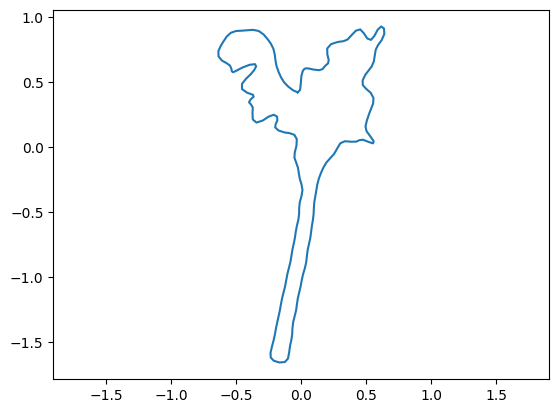

In [13]:
# # Process two different shapes

polygon_data_1 = pd.read_csv(csv_paths[0]).values
ic(polygon_data_1)
polygon_data_2 = pd.read_csv(csv_paths[1]).values

feat1 = get_feature_vector(polygon_data_1)
feat2 = get_feature_vector(polygon_data_2)

# Compare them
dist = euclidean(feat1, feat2)
print(f"Morphological distance: {dist:.4f}")

# Visualize the normalized reconstruction
y, x = reconstruct(feat2)
plt.plot(x, y)
plt.axis('equal')
plt.show()
